# C-M-009: Machine Learning Lab II ’21-22
Lab. 4/Project (Given December 27, 2021; Due January 8, 2022) 

# 💊 Drug Design

✍🏻 Joseph Ben | TLP 22

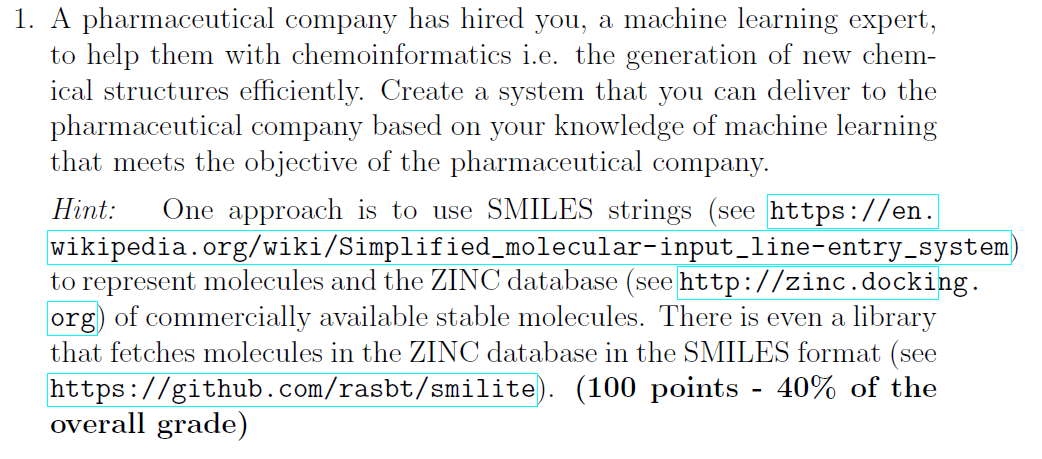

### Importing, Preprocessing and Splitting data

In [133]:
# Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import tarfile

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import Model
from keras.layers import Input
from tensorflow.keras import backend as K
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers

from sklearn.model_selection import train_test_split


In [ ]:
pip install smilite

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
zinc_df = pd.read_csv("/content/drive/MyDrive/SMILES/zinc.csv") 

In [77]:
zinc_df

,zinc_id,smiles
0,ZINC000000008151,C[C@H]1[C@@H](O)[C@H](CO)O[C@@H](O)[C@@H]1N
1,ZINC000000008153,CC[C@@H]1[C@@H](N)[C@@H](O)O[C@@H](CO)[C@@H]1O
2,ZINC000000008155,CC1(C)[C@@H](N)[C@@H](O)O[C@@H](CO)[C@@H]1O
3,ZINC000000018276,CS[C@@H]1CN[C@@H](CO)[C@H](O)[C@H]1O
4,ZINC000000018279,CS[C@@H]1[C@@H](O)CN[C@@H](CO)[C@@H]1O
...,...,...
427488,ZINC000242463989,O[Cl+3](O)(O)O
427489,ZINC000247713634,O1[SiH2][SiH2]O[SiH2][SiH2]1
427490,ZINC000252581626,O[Si](O)(O)F
427491,ZINC000685945533,Cn1nnnc1S(=O)(=O)F


In [78]:
# Split the data into Train and Test sets

x_train, x_test = train_test_split(zinc_df['smiles'], test_size = 0.1, random_state = 42)

print(x_train.shape)
print(x_test.shape)

(384743,)
(42750,)


In [79]:
# Unique character set with start and end tokens
char_set = set(''.join(list(zinc_df.smiles)) + '!E')

# int to character mapping
int_to_char = dict((i, c) for i, c in enumerate(char_set))

# character to int mapping
char_to_int = dict((c, i) for i, c in enumerate(char_set))

# maximum length of sequence
seq_len = max([len(smile) for smile in zinc_df.smiles]) + 5  

print(f'\nCharacter to integer dictionary: \n {char_to_int}')
print(f'\nInteger to character dictionary: \n {int_to_char}')


Character to integer dictionary: 
 {'@': 0, '1': 1, 'P': 2, '!': 3, 'n': 4, '-': 5, '+': 6, 'i': 7, '8': 8, '#': 9, '7': 10, 'E': 11, 'C': 12, '4': 13, 'B': 14, 'S': 15, '5': 16, '(': 17, ')': 18, '2': 19, ']': 20, 'c': 21, '3': 22, '[': 23, 'r': 24, '=': 25, 'H': 26, '/': 27, 'I': 28, 'o': 29, '\\': 30, 'F': 31, 'O': 32, 'l': 33, 'N': 34, 's': 35, '6': 36, 'p': 37}

Integer to character dictionary: 
 {0: '@', 1: '1', 2: 'P', 3: '!', 4: 'n', 5: '-', 6: '+', 7: 'i', 8: '8', 9: '#', 10: '7', 11: 'E', 12: 'C', 13: '4', 14: 'B', 15: 'S', 16: '5', 17: '(', 18: ')', 19: '2', 20: ']', 21: 'c', 22: '3', 23: '[', 24: 'r', 25: '=', 26: 'H', 27: '/', 28: 'I', 29: 'o', 30: '\\', 31: 'F', 32: 'O', 33: 'l', 34: 'N', 35: 's', 36: '6', 37: 'p'}


In [80]:
print(f'Character set: {str(char_set)}', f'\nNumber of characters: {len(char_set)}\t Length of sequence: {seq_len}')

Character set: {'@', '1', 'P', '!', 'n', '-', '+', 'i', '8', '#', '7', 'E', 'C', '4', 'B', 'S', '5', '(', ')', '2', ']', 'c', '3', '[', 'r', '=', 'H', '/', 'I', 'o', '\\', 'F', 'O', 'l', 'N', 's', '6', 'p'} 
Number of characters: 38	 Length of sequence: 67


### Onehot

In [81]:
# one-hot encoding
def one_hot(smiles):
  # array of shape (num_examples, time_stamp, input_dim) initialized with zeros 
  one_hot =  np.zeros((smiles.shape[0], seq_len, len(char_set)), dtype = np.int8)
  # iterate over each smile string
  for i, smile in enumerate(smiles):
    # encode the start token
    one_hot[i, 0, char_to_int["!"]] = 1
    # encode the characters of smile string
    for j, char in enumerate(smile):
        one_hot[i, j + 1, char_to_int[char]] = 1
    # encode the end token
    one_hot[i, len(smile) + 1:, char_to_int['E']] = 1
  # return input and the output
  return one_hot[:, 0:-1, :], one_hot[:, 1:, :]

(5000, 66, 38)
(5000, 66, 38)


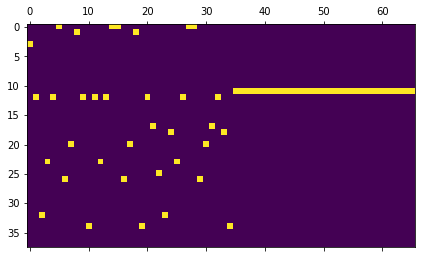

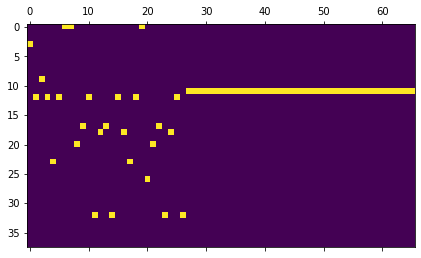

In [136]:
# One hot encoded train and validation data
X_train, Y_train = one_hot(x_train.values[0:5000])
X_test, Y_test = one_hot(x_test.values[0:5000])

print(X_train.shape)
print(X_test.shape)

# show the one hot encoded version of the string
plt.matshow(X_train[0].T)
plt.matshow(X_test[0].T)

Have taken only 5000 rows due to training time constraint.

In [137]:
# int_to_char dictionary vectorized to readable string
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!CO[C@H]1CNC[C@@H]1NC(=O)[C@@H](C)NEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

### Building Model

In [138]:
# input shape of the model
input_shape = X_train.shape[1:]

# output shape of the model
output_dim = Y_train.shape[-1]

# lstm units
lstm_dim = 64

# latent dimension 
latent_dim = 64


#### Encoder


In [139]:
# Encoder model

unroll = False

# input layer of the encoder
encoder_inputs = layers.Input(shape = input_shape)
encoder = layers.LSTM(lstm_dim, return_state = True, unroll = unroll)

# internal states of the encoder
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# concatenation of cell state and hidden state 
concat_states = layers.Concatenate(axis = -1)([state_h, state_c])

# latent layer
latent = layers.Dense(latent_dim, activation = "relu")
latent_outputs = latent(concat_states)

#### Decoder

In [140]:
# decode the cell and hidden states of the encoder
h_decoded =  layers.Dense(lstm_dim, activation = "relu")
h_decoded_state = h_decoded(latent_outputs)
c_decoded =  layers.Dense(lstm_dim, activation = "relu")
c_decoded_state = c_decoded(latent_outputs)
# enocder states
encoder_states = [h_decoded_state, c_decoded_state]

# input layer for decoder
decoder_inputs = layers.Input(shape = input_shape)

# hidden layers
decoder_lstm = layers.LSTM(lstm_dim, return_sequences = True, unroll = unroll)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state = encoder_states)

decoder_outputs = layers.Dense(output_dim, activation = 'softmax')(decoder_outputs)

# Define the model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# print model summary
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 66, 38)]     0           []                               
                                                                                                  
 lstm_19 (LSTM)                 [(None, 64),         26368       ['input_31[0][0]']               
                                 (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                                  
 concatenate_5 (Concatenate)    (None, 128)          0           ['lstm_19[0][1]',                
                                                                  'lstm_19[0][2]']         

### Compiling model


In [145]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

from tensorflow.keras.optimizers import RMSprop, Adam
opt=Adam(lr=0.005) 
model.compile(optimizer=opt, loss='categorical_crossentropy')
model.fit([X_train,X_train],Y_train,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


20/20 [==============================] - 13s 447ms/step - loss: 1.2705 - val_loss: 1.1412 - lr: 0.0050
Epoch 2/50
20/20 [==============================] - 8s 400ms/step - loss: 1.0994 - val_loss: 1.0422 - lr: 0.0050
Epoch 3/50
20/20 [==============================] - 8s 400ms/step - loss: 0.9578 - val_loss: 0.8349 - lr: 0.0050
Epoch 4/50
20/20 [==============================] - 8s 396ms/step - loss: 0.7344 - val_loss: 0.6450 - lr: 0.0050
Epoch 5/50
20/20 [==============================] - 8s 400ms/step - loss: 0.6004 - val_loss: 0.5687 - lr: 0.0050
Epoch 6/50
20/20 [==============================] - 8s 399ms/step - loss: 0.5432 - val_loss: 0.5260 - lr: 0.0050
Epoch 7/50
20/20 [==============================] - 8s 400ms/step - loss: 0.5131 - val_loss: 0.5021 - lr: 0.0050
Epoch 8/50
20/20 [==============================] - 8s 400ms/step - loss: 0.4887 - val_loss: 0.4838 - lr: 0.0050
Epoch 9/50
20/20 [==============================] - 8s 402ms/step - loss: 0.4728 - val_loss: 0.4718 - lr: 

### Validation

In [147]:
for i in range(100):
    idxs_o = model.predict([X_test[i:i+1], X_test[i:i+1]]) #Can't be done as output not necessarely 1
    idxs = np.argmax(idxs_o, axis=2)
    pred=  "".join([int_to_char[h] for h in idxs[0]])[:-1]
    idxs2 = np.argmax(X_test[i:i+1], axis=2)
    true =  "".join([int_to_char[k] for k in idxs2[0]])[1:]
    if true != pred:
        print (true, pred)

C#C[C@@](CO)(OC)[C@H](O)COEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CNCCC@HH1O))(C)CCC@H](O)COEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
O/N=C1\CN[C@@H]2C=NN[C@H]12EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE C=N=C1\NN[C@@H]2C[NN[C@H]12EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
C[C@@H](N)[C@]1(C)NCC(=O)NC1=OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE C[C@@H](O)CC@@((OOCCC(=O)NC1=OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
O=C1C=NN[C@H]2CCNN=C12EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE C=C1NNCNCC@H]2CNNC1C22EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
NC[C@H]1NC=NCC[C@H]1NEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE CC(C@@]1CC(NN(NC@H]1OEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
O=C1CNC[C@@H]2N[C@]12[C@@H]1CN1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE C=C1N[[[C@@H]2[[C@@1([C@@H]1CN1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
C=C1[C@H]2N[C@H]2[C@@H]([C@@H]2CN2)[C@H]1NEEEEEEEEEEEEEEEEEEEEEEE C[C1[C@@]2N[C@@]2[C@@H](OC@@H]3CN3)[C@@]1OEEEEEEEEEEEEEEEEEEEEEEE
C[C@H]1[C@@H](C#N)O[C@H](CO)[C@H](O)[C@@H]1OEEEEEEEEEEEEEEEEEEEEE C[C@@]1[C@

### SMILES -> latent space

In [148]:
# constructing the smiles to latent space model 
smiles_to_latent_space = tf.keras.Model(encoder_inputs, latent_outputs)

# saving the model
smiles_to_latent_space.save("smile_latent.h5")

In [162]:
# convert validation data into latent space
x_latent = smiles_to_latent_space.predict(X_test)

 latent space -> LSTM

In [163]:
# latent input layer for decoding smiles data
latent_input = layers.Input(shape = (latent_dim,))

# reuse earlier dense layers
h_decoded_state_2 =  h_decoded(latent_input)
c_decoded_state_2 =  c_decoded(latent_input)

latent_to_states_model = tf.keras.Model(latent_input, [h_decoded_state_2, c_decoded_state_2])
latent_to_states_model.save("latent_state.h5")

In [165]:
# Model for random sampling
inf_decoder_inputs = layers.Input(batch_shape = (1, 1, input_shape[1]))
inf_decoder_lstm = layers.LSTM(lstm_dim, return_sequences = True, unroll = False, stateful = True)

inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = layers.Dense(output_dim, activation = 'softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)

sample_model = tf.keras.Model(inf_decoder_inputs, inf_decoder_outputs)

In [166]:
# Transfer learned weights
for i in range(1, 3):
  sample_model.layers[i].set_weights(model.layers[i + 6].get_weights())
sample_model.save("sample_model.h5")

sample_model.summary()

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(1, 1, 38)]              0         
                                                                 
 lstm_25 (LSTM)              (1, 1, 64)                26368     
                                                                 
 dense_51 (Dense)            (1, 1, 38)                2470      
                                                                 
Total params: 28,838
Trainable params: 28,838
Non-trainable params: 0
_________________________________________________________________


In [171]:
def latent_to_smiles(latent):
    #decode states and set Reset the LSTM cells with them
    states = latent_to_states_model.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0],states[1]])
    #Prepare the input char
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,38))
    samplevec[0,0,startidx] = 1
    smiles = ""
    #Loop and predict next char
    for i in range(28):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,38))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

### Final Output

In [173]:
for i in range(0,20):
  smiles = latent_to_smiles(x_latent[i:i+1])
  print(smiles)

CN1CCN[C@@H](CO)[C@@H]1O
C[C@@H](O)C(=O)NC(=O)C(=O)CO
C[C@@H](O)C(=O)NC(=O)[C@@H]1
CN1CCNC(=O)[C@@H]1CN1
CN1CCNC(=O)[C@@H]1CN1
C[C@@H](O)[C@@H](O)C(=O)NC(=
C[C@@H]1O[C@@H](O)[C@@H](O)[
C[C@@H]1O[C@@H](O)[C@@H](O)[
CN1CCNC(=O)[C@@H]1CN1
C[C@@H](O)C(=O)NC(=O)C(=O)CO
C[C@@H]1O[C@@H](O)[C@@H](O)[
C[C@@H](O)C(=O)NC(=O)C(=O)CC
NC(=O)CNCCO
C[C@@H]1O[C@@H](O)[C@@H](O)[
CNC(=O)CNC(=O)CCN
C[C@@H](O)C(=O)NC(=O)C(=O)CO
C[C@@H](O)[C@@H](O)C(=O)NC(=
C[C@@H]1O[C@@H](O)[C@@H](O)[
C[C@@H](O)C(=O)NC(=O)C(=O)CO
C[C@@H](O)C(=O)NC(=O)[C@@H](
